# Set-up of transient (GRB) analysis

In [1]:
# basic imports
from __future__ import print_function
from csky.ipyconfig import *
%matplotlib inline

mp_cpus = 10

In [2]:
mrichman_mpl()
print (now ())

2019-05-01 07:40:07.510832


In [3]:
repo = selections.Repository()
repo.local_root  = '/data/ana/analyses'

# deg: ra & dec in degrees (not extension) !!!
src = utils.Sources (ra=[34.82, 1.1], dec=[43.21, 0.1], deg=True , mjd=[57623.1234, 57613.1234], sigma_t=[5.0/86400, 0.001], t_100=[500.0/86400, 1e3/86400], name=["Fake_GRB", "trial"],
                     extension=[0.001, 0.0001], t_start=[57623.0234, 57613.0234], t_stop=[57623.5234, 57613.5234])

### Load the GFU data
ana_dir = utils.ensure_dir ('/home/pcoppin/csky_notebooks/GFU_test_dir')
specs = selections.GFUDataSpecs.gfu_IC86

### Load Transients Tracks (note, some of the sigma values (pos_error) in transients tracks are zero, which can give warnings!)
# ana_dir = utils.ensure_dir ('/home/pcoppin/csky_notebooks/Transient_test_dir')
# specs = selections.TransientDataSpecs.trt_2011_2015

In [4]:
### Analysis is loaded from saved files this way, if the files exist. These files should be removed each time the code is updated!

#%time ana = analysis.Analysis (repo, specs, src=[], dir=ana_dir)

ana = analysis.Analysis (repo, specs, src=src, dir=ana_dir)

#ana.save(ana_dir)

a        = ana.anas[0]
ds       = a.ds           # ds: dataset
data     = a.data

bg_data     = a.bg_data
sig         = a.sig
livetime    = a.livetime
bg_livetime = a.bg_livetime
grl         = a.grl

zenith_bins = a.kw_space_bg['hkw']["bins"]

Setting up Analysis for:
GFU_IC86
Setting up GFU_IC86...
Reading /data/ana/analyses/gfu/current/IC86_2011_MC.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2016_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2017_data.npy ...
Reading /data/ana/analyses/gfu/current/IC86_2018_data.npy ...
Reading /data/ana/analyses/gfu/current/GRL/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/current/GRL/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/current/GRL/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/current/GRL/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/current/GRL/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/current/GRL/IC86_2016_data

In [5]:
#ana.save(ana_dir)

-> /home/pcoppin/csky_notebooks/GFU_test_dir/GFU_IC86.subanalysis.npy    


# Define likelihood, injections & trials

In [6]:
# Called once for each subanalysis (IC40, IC59, ...)
def get_llh(a, src, flux, cut_n_sigma):
    if not hasattr (a, 'E2_acc_param'):
        a.E2_acc_param = a.get_custom_flux_acc_parameterization (flux)
    if not hasattr (a, 'E2_Emodel'):
        a.E2_Emodel = a.get_custom_flux_energy_pdf_ratio_model (flux)
    ## 2D bg space PDF
    bg_space_param = pdf.BgAzimuthSinDecParameterization (a.bg_data, smooth=(1,4), hkw=a.kw_space_bg['hkw'])
    #bg_space_param = a.bg_space_param This is BgSinDecParameterization
    # spatially point like
    space_model = pdf.PointSourceSpacePDFRatioModel (
        a, src, bg_space_param, a.E2_acc_param, cut_n_sigma=cut_n_sigma)
    # gaussian flare
    time_model = pdf.TransientTimePDFRatioModel (a, src)
    # E^-2 spectrum
    energy_model = a.E2_Emodel
    #energy_model = a.energy_pdf_ratio_model
    # put it all together
    spacetime_model = pdf.SpaceTimePDFRatioModel (space_model, time_model)
    pdf_ratio_model = pdf.MultiPDFRatioModel (spacetime_model, energy_model)
    llh_model = llh.LLHModel (pdf_ratio_model, time_model.nb, extended=True)
    return llh_model

# Called once for each subanalysis (IC40, IC59, ...)
def get_injs (a, llh_model, src, cut_n_sigma, sig, flux):
    # check which event data we need to keep
    prm = llh_model.pdf_ratio_model
    keep = prm.keep
    time_model = prm.acc_weighted_model.time_model
    # dec band cutter
    selector = inj.DecBandSelector (src, cut_n_sigma=cut_n_sigma)
    t_selector = inj.TimeWindowSelector (time_model.src_mjd_min, time_model.src_mjd_max)
    # t: truth: not scrambled
    t = inj.DataInjector (a, t_selector (selector (a.data)), keep, randomizers=[])
    # b: background: MJD shuffling
    b = inj.DataOnOffInjector (a, time_model, keep, randomizers=[inj.MJDShuffleRandomizer ()], cut_n_sigma=cut_n_sigma,)
    # s: signal injector matching TXS fitted flare time and width
    s = None if not sig else inj.TransientInjector (a, time_model, flux, keep)
    return t, b, s

# Called once
def get_tr(src, ana, mp_cpus=mp_cpus, cut_n_sigma=5, sig=True, flux=hyp.PowerLawFlux (2), **fitter_args):
    llh_kw = dict (src=src, flux=flux, cut_n_sigma=cut_n_sigma)
    inj_kw = dict (src=src, cut_n_sigma=cut_n_sigma, sig=sig, flux=flux)
    fargs = dict ()
    fargs.update (fitter_args)
    return trial.get_trial_runner(ana, get_llh, get_injs, llh_kw=llh_kw, inj_kw=inj_kw, fitter_args=fargs, mp_cpus=mp_cpus)

In [7]:
tr = get_tr(src, ana)

In [8]:
tr.get_one_fit(TRUTH=True, _full_output=True)               # What does truth=True mean? ==> Don't do a trial but calculate the TS-value of the real data

(0.0,
 {'ns': 0.0},
 {},
 {'_fit_null': False,
  '_full_output': True,
  '_ns_min': 0,
  '_ns_tol': 0.0001,
  '_taylor_tol': 0.001,
  '_ts_min': 0})

In [9]:
# get XXX trials
%time bg = tr.get_many_fits(100000)
# better fit with floc=0 (analysis-specific; YMMV)
bg = dists.Chi2TSD (bg, floc=0)
bg

Performing 100000 background trials using 10 cores:
     100000/100000 trials complete.   
CPU times: user 84 ms, sys: 379 ms, total: 463 ms
Wall time: 38.1 s


Chi2TSD(100000 trials, eta=0.013, ndof=1.487, median=0.000 (from fit 0.000))

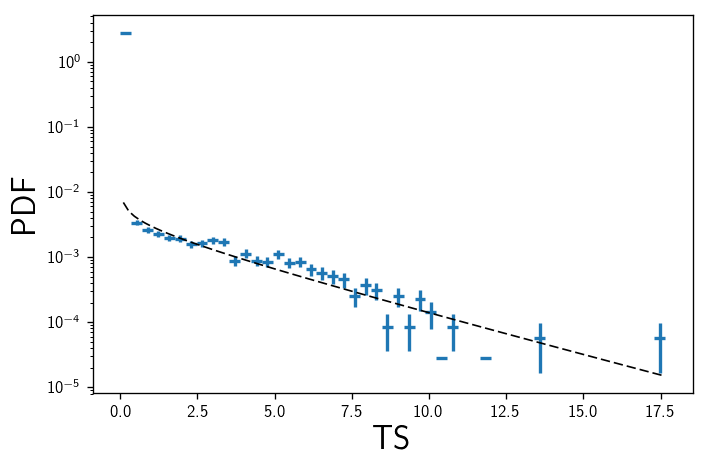

In [10]:
fig, ax = plt.subplots ()
h = bg.get_hist (bins=50)
hl.plot1d (ax, h.normalize (), crosses=True)
x = np.linspace (.1, h.range[0][-1], 100)
ax.semilogy (x, bg.eta * bg.chi2.pdf (x), 'k--', lw=1)
plt.xlabel("TS", size=20)
plt.ylabel("PDF", size=20)
plt.tight_layout()
plt.savefig("BG_TS_PDF_FAKE_GRBs.pdf",bbox_inches='tight')
plt.show()

## Fake TXS GRB

In [13]:
co = selections.Coordinates
src = co.to_sources (co.txs_0506_056)
txs_mjd = 58018.87118560489
src['t_100'] = np.r_[1e3/86400.]
src['mjd'] = np.r_[txs_mjd] - 0.5 * src.t_100
src['sigma_t'] = np.r_[0]

tr = get_tr (src, ana)
%time tr.get_one_fit (TRUTH=True)

CPU times: user 1.14 ms, sys: 36 µs, total: 1.18 ms
Wall time: 1.19 ms


[30.11854921703225, 0.999999893941014]

In [14]:
%time bg = dists.Chi2TSD (tr.get_many_fits (100000, mp_cpus=10))
%time sigtrials = tr.get_many_fits (10000, n_sig=3, mp_cpus=10)

Performing 100000 background trials using 10 cores:
     100000/100000 trials complete.   
CPU times: user 167 ms, sys: 470 ms, total: 637 ms
Wall time: 7.73 s
Performing 10000 trials with n_sig = 3.000 using 10 cores:
      10000/10000 trials complete.   
CPU times: user 26.2 ms, sys: 480 ms, total: 506 ms
Wall time: 7.59 s


In [ ]:
"""GRB number 23: 150716B with (ra,dec,T100)=(286.64,14.46, 3.28e+01) (GBM)
                       at 2015-07-16 13:14:31.090000 [3 ontime] 
TS                  0.0280323881954
ns                  0.158217938667
grbllh result:
TS                  0.0220475275626
ns                  0.141227675527
         S: [1.76421459e-13 3.15866085e-22 1.92956473e+01]
         T: [0.00811715 0.61994902 0.26468431]
         E: [0.31855353 0.46231826 0.38407553]
     S*T*E: [4.56181445e-16 9.05315631e-23 1.96157169e+00]
GRB number 32: 150802B with (ra,dec,T100)=(201.54,17.18, 9.98e+00) (GBM)
                       at 2015-08-02 04:57:38.930000 [2 ontime] 
TS                  0.0944435575637
ns                  0.276675356627
grbllh result:
TS                  0.626938816417
ns                  0.598111712457
         S: [2.56277572e+00 2.51018136e-28]
         T: [3.12881903 1.44555126]
         E: [0.0937467  0.42715558]
     S*T*E: [7.51704310e-01 1.54997495e-28]
GRB number 56: 150928A with (ra,dec,T100)=(83.78,34.24, 5.35e+01) (GBM)
                       at 2015-09-28 08:36:48.790000 [4 ontime] 
TS                  0.852194598042
ns                  0.69324031751
grbllh result:
TS                  1.23160393577
ns                  1.07971076872
         S: [1.00455758e+00 1.13184573e-02 7.81642614e-38 3.35755931e-09]
         T: [2.2804182  2.2804182  3.10165323 0.58074634]
         E: [2.20598115 3.04430269 0.98973663 3.35443745]
     S*T*E: [5.05348674e+00 7.85759367e-02 2.39950200e-37 6.54078502e-09]
GRB number 95: 160127A with (ra,dec,T100)=(225.98,0.07, 7.14e+00) (non-GBM)
                       at 2016-01-27 08:43:05.560000 [1 ontime] 
TS                  7.37934597725
ns                  0.99072467016
grbllh result:
TS                  7.31886678405
ns                  0.990437160262
         S: [50.95406089]
         T: [2.56370781]
         E: [0.32104915]
     S*T*E: [41.93907522]
GRB number 113: 160303B with (ra,dec,T100)=(163.49,56.94, 4.81e+01) (GBM)
                       at 2016-03-03 04:49:33.790000 [2 ontime] 
TS                  0.984850582416
ns                  0.695232790062
grbllh result:
TS                  0.676772324569
ns                  0.614294191208
         S: [1.20122441 0.08766691]
         T: [2.33627415 0.00978557]
         E: [2.03697686 0.70436171]
     S*T*E: [5.71655051e+00 6.04251131e-04]"""

## Load GRBweb data

In [15]:
import sqlite3
import pandas

db = sqlite3.connect("GRB_data/GRBweb2.sqlite")
table = pandas.read_sql_query("Select * from Summary where T90 is not null AND GRB_name like 'GRB150716Z%';", db) #AND pos_error is not null
db.close()
table

,id,GRB_name,GRB_name_Fermi,t_trigger,ra,decl,pos_error,T90,T90_error,T90_start,fluence,fluence_error,redshift,T100,GBM_located,mjd
0,69,GRB150716Z,GRB150716552,47671.873,286.64,14.46,None,32.768,5.684,47671.873,0.000001,3.218400e-08,None,32.768,1,57219.551758


In [16]:
GRBs_extension = np.array([6.5])
GRBs_extension = np.radians(GRBs_extension)

src = utils.Sources(ra=np.array(table.ra), dec=np.array(table.decl), deg=True, extension=GRBs_extension, mjd=np.array(table.mjd),
                    t_100=np.array(table.T90)/86400, name=np.array(table.GRB_name))
src['sigma_t'] = np.minimum (30, np.maximum (2, np.array(table.T90))) / 86400 

def var_name_conversion(varname):
    if( varname=="GRB_name" ):
        return "name"
    elif( varname=="ra" ):
        return "ra"
    elif( varname=="decl" ):
        return "dec"
    elif( varname=="mjd" ):
        return "mjd"
    elif( varname=="T90" ):
        return "t_100"
    elif( varname=="pos_error" ):
        return "extension"
    return "None"

grbs = utils.Arrays ({var_name_conversion(var_name): np.array(table[str(var_name)]) for var_name in ["GRB_name", "ra", "decl", "T90", "pos_error"]}) #table.keys()
grbs

Arrays(1 items | columns: dec, extension, name, ra, t_100)

In [17]:
grbs["extension"] = np.array([6.5])
for key in grbs.keys():
    print(key, grbs[key])

dec [14.46]
extension [6.5]
name [u'GRB150716Z']
ra [286.64]
t_100 [32.768]


## GRB analysis unblinding

In [18]:
%time trs = [get_tr (src[i:i+1], ana, sig=False, cut_n_sigma=np.inf) for i in xrange (len (src))] # Why is sig set to False here, ah we don't need to inject signal events ok!

CPU times: user 757 ms, sys: 171 ms, total: 928 ms
Wall time: 925 ms


In [19]:
%time tsns = np.array ([tri.get_one_fit (TRUTH=True) for tri in trs])

CPU times: user 980 µs, sys: 2 ms, total: 2.98 ms
Wall time: 2.52 ms


In [20]:
def get_time_model (tri):
    L = tri.get_one_llh (TRUTH=True)
    return tri.bg_injs[0].time_model

def print_weights (tri, indent=4):
    L = tri.get_one_llh (TRUTH=True).llhs[-1]
    for main_evaluator in L.evaluators:
        ste, ee = main_evaluator.evaluators
        se, te = ste.space_evaluator, ste.time_evaluator
        things = [('S', se.evaluate_sparse), ('T', te.evaluate_sparse),
                  ('E', ee), ('S*T*E', main_evaluator), ('sigma', np.degrees (se.ev.sigma))]
        for (kind, e) in things:
            print (' ' * indent + '{:>10}: {}'.format (kind, e ()[0] if callable (e) else e))
            

### This function does the unblinding. It has been modified to cope with my GRBlist
def print_grb_crosscheck (tsns, src, trs, ana, gl=None): #, grbs
    pos_grbs = np.where (tsns[:,0] > 0)[0]
    a = ana.anas[0]
    if gl is None:
        gl = utils.Arrays (ts=np.array ([]), ns=np.array ([]), i=np.array ([], dtype=int))
    for pos_grb in np.unique (np.r_[pos_grbs, gl.i]):
        tri = trs[pos_grb]
        tm = get_time_model (tri)
        n_ontime = np.sum ((tm.src_mjd_min[0] < a.data.mjd) & (a.data.mjd < tm.src_mjd_max))
        print(grbs.name[pos_grb])
        
        #print ('GRB number {}: {} with (ra,dec,T100)=({:.2f},{:.2f}, {:.2e}) {}\n{}at {} [{} ontime] {}'.format (
        #    pos_grb, grbs.name[pos_grb], src.ra_deg[pos_grb], src.dec_deg[pos_grb], grbs.t_100[pos_grb], 'XXXXX(non)GBM' , 23 * ' ', 0.0#ogrbs[pos_grb].t_start,
        #    n_ontime, '    * non-null in grbllh' if not pos_grb in pos_grbs else ('    * null in grbllh' if not pos_grb in gl.i else '')))
        print (tri.format_result (tsns[pos_grb]))
        if pos_grb in gl.i:
            print ('grbllh result:')
            print (tri.format_result (np.ravel ([2*gl.ts[gl.i==pos_grb], gl.ns[gl.i==pos_grb]])))
        print ()
        print_weights (tri, indent=0)
        print ()
        
print_grb_crosscheck (tsns, src, trs, ana)

GRB150716Z
TS                  0.395828589279
ns                  0.504722231996

         S: [ 0.          0.          0.         38.11027341]
         T: [0.00434701 0.73153794 0.64964556 0.28042085]
         E: [0.34624005 0.90205536 0.52729425 0.34260438]
     S*T*E: [0.         0.         0.         3.66138393]
     sigma: [0.21602234 0.14296378 0.92054254 2.587786  ]



## Energy distribution of the IceCube events in the analysis afo zenith

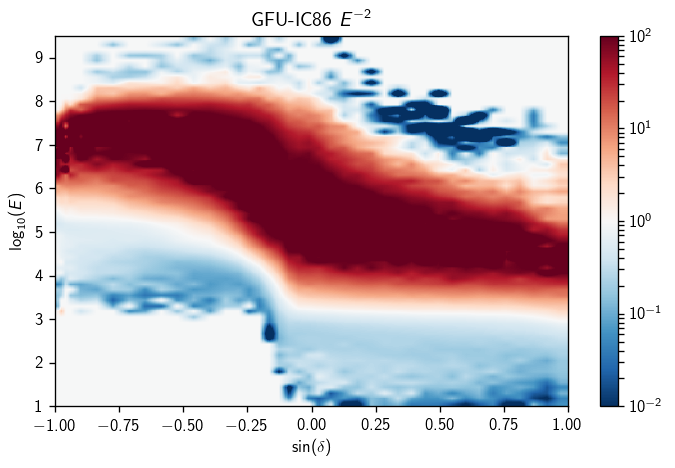

In [11]:
fig, ax = plt.subplots ()
csp.plot_energy_pdf (ax, a, 2, cbar=True, cmap='RdBu_r', vmin=1e-2, vmax=1e2, log=True)
ax.set_xlabel (r'$\sin(\delta)$')
ax.set_ylabel (r'$\log_{10}(E)$')
ax.set_title (re.sub ('_', '-', a.key) + r' $E^{{-{}}}$'.format (2))
plt.tight_layout()

## Fermi-GBM healpix maps

In [13]:
GBM_map = hp.read_map ('/home/pcoppin/csky_tutorial/glg_healpix_all_bn180130049_v00.fit')

In [14]:
GBM_nside = nside = hp.get_nside (GBM_map)
npix = GBM_map.size
r = hp.rotator.Rotator (rot=-180)
theta, phi = hp.pix2ang (nside, np.r_[:npix])
theta_rot, phi_rot = r (theta, phi)
rot_GBM_map = hp.get_interp_val (GBM_map, theta_rot, phi_rot)

/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/RHEL_7_x86_64/lib/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


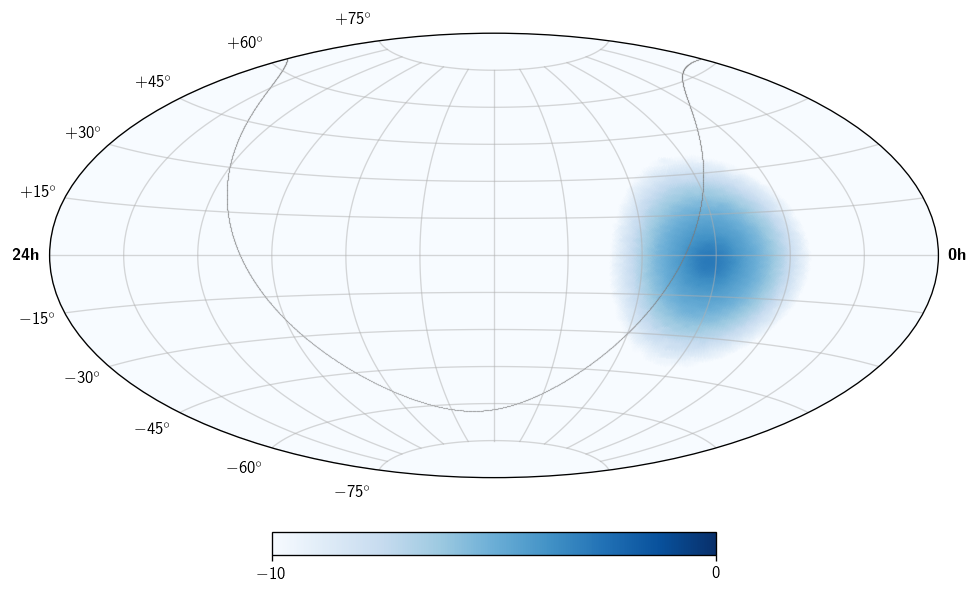

In [15]:
def plot_result (v, clabel='', title='', vmin=None, vmax=None, cmap='viridis', projection='aitoff'):
    if vmin is None:
        vmin = 0
    if vmax is None:
        vmax = np.ceil (v.max())
    fig, ax = plt.subplots (figsize=(8,6), subplot_kw=dict (projection=projection))
    sp = csp.SkyPlotter (pc_kw=dict (cmap=cmap, vmin=vmin, vmax=vmax))
    v = hp.ud_grade (v, 256)
    mesh, cb = sp.plot_map (ax, v, n_ticks=2, titleticks=bool (title))
    sp.plot_gp (ax, color='.5', lw=.5, alpha=.25)
    ax.grid (alpha=.5, ls='-')
    cb.set_label (clabel)
    ax.set_title (title)
    plt.tight_layout()
    return fig, ax

plot_result (np.log10 (rot_GBM_map), cmap='Blues', vmin=-10, vmax=0);

In [11]:
def get_disc_pixels(events, nside, radius):
    r""" Query disc of given radius around selected events.

    Parameters
    ----------
    events : np.ndarray
        Array of data events
    nside : int
        Resolution of the healpix map to use
    radius : float
        Radius around each event which is used to
        select pixels

    Returns
    -------
    src_pix : np.ndarray
        List of pixels within 'radius' of the data events
    """
    # Convert ra and dec of events to cartesian coordinates
    src_ra = events['ra']
    src_dec = events['dec']
    src_theta = np.pi / 2 - src_dec
    src_phi = src_ra
    src_x = np.cos(src_phi) * np.sin(src_theta)
    src_y = np.sin(src_phi) * np.sin(src_theta)
    src_z = np.cos(src_theta)

    # get pixels within given raidus of each event
    src_pix = np.empty(0)
    for i in range(len (events)):
        src_pix = np.concatenate((
            src_pix,
            hp.query_disc(nside, [src_x[i], src_y[i], src_z[i]], radius * events['sigma'][i])))

    src_pix = np.unique(src_pix.astype(int))

    return src_pix

In [12]:
gw_map = GBM_map
gw_map[gw_map == 0] = 1e-10 * gw_map[gw_map > 0].min ()
gw_nside = hp.get_nside (gw_map)
gw_map_normed = gw_map / np.sum (gw_map) / hp.nside2pixarea (gw_nside)
gw_map_normed = np.exp (np.log (gw_map_normed) - np.nanmax (np.log (gw_map_normed)))

def get_llh_gw (a, src, flux):
    ## 2D bg space PDF
    #bg_space_param = pdf.BgAzimuthSinDecParameterization (a.data, smooth=2, hkw=a.kw_space_bg['hkw'])
    # spatially point like
    space_model = pdf.PointSourceSpacePDFRatioModel (a, src, a.bg_space_param, a.acc_param)
    # gaussian flare
    time_model = pdf.TransientTimePDFRatioModel (a, src)
    # E^-2 spectrum
    #energy_model = a.E2_Emodel
    # fit spectrum
    energy_model = a.energy_pdf_ratio_model
    # put it all together
    spacetime_model = pdf.SpaceTimePDFRatioModel (space_model, time_model)
    pdf_ratio_model = pdf.MultiPDFRatioModel (spacetime_model, energy_model)
    llh_model = llh.LLHModel (pdf_ratio_model, time_model.nb, extended=True)
    return llh_model

def get_injs_gw (a, llh_model, src, cut_n_sigma, sig, flux):
    # avoid this if trial already set?
    if cut_n_sigma < np.inf and not sig:
        return None, None, None
    # check which event data we need to keep
    prm = llh_model.pdf_ratio_model
    keep = prm.keep
    time_model = prm.acc_weighted_model.time_model
    # dec band cutter
    selector = inj.DecBandSelector (src, cut_n_sigma=cut_n_sigma)
    t_selector = inj.TimeWindowSelector (time_model.src_mjd_min, time_model.src_mjd_max)
    # t: truth: not scrambled
    t = inj.DataInjector (a, t_selector (selector (a.data)), keep, randomizers=[])
    # b: background: from off-time data
    b = inj.DataOnOffInjector (a, time_model, keep,
                               cut_n_sigma=cut_n_sigma,)
    # s: signal injector
    s = None if not sig else inj.TransientInjector (
        a, time_model, flux, keep)
    return t, b, s

def get_tr_gw (src, ana=anag, mp_cpus=mp_cpus, cut_n_sigma=5, sig=False,
               flux=hyp.PowerLawFlux (2), **fitter_args):
    # pass through the src coords
    llh_kw = dict (src=src, flux=flux)
    inj_kw = dict (src=src, cut_n_sigma=cut_n_sigma, sig=sig, flux=flux)
    fargs = dict (gamma=np.r_[1:4.01:1.5])
    #ra, dec = src.ra[0], src.dec[0]
    #prior = gw_map_normed[hp.ang2pix (gw_nside, pi/2-dec, ra)]
    #fargs['prior'] = lambda **p: prior
    fargs.update (fitter_args)
    # get a TrialRunner
    return trial.get_trial_runner (
        ana, get_llh_gw, get_injs_gw,
        llh_kw=llh_kw, inj_kw=inj_kw,
        fitter_args=fargs, #param_names=param_names,
        mp_cpus=mp_cpus)

def get_tr_gw_skymap (ra, dec, cut_n_sigma=5, _fit_null=False):
    gw_mjd = 57382.152001999784
    txs_mjd = 58018.87118560489
    mjd = gw_mjd
    src = utils.Sources (ra=ra, dec=dec, mjd=mjd - 500/86400., t_100=1000/86400., sigma_t=0)
    return get_tr_gw (src, anag, cut_n_sigma=cut_n_sigma, _fit_null=_fit_null)
def get_selector_gw (dec):
    return lambda arr: arr
    return inj.DecBandSelector (utils.Sources (dec=dec))

gw_mjd = 57382.152001999784
txs_mjd = 58018.87118560489
ra, dec = co.txs_0506_056[:2]
src = utils.Sources (ra=ra, dec=dec, mjd=gw_mjd - 500/86400., t_100=1000/86400., sigma_t=0)

NameError: name 'GBM_map' is not defined

## Calculate sensitivity & discovery potential

### Calculate the sensitivity for a specific GRB at a specific declination

In [11]:
def get_tr_for_grb_sens (sindec, t_100, flux=hyp.PowerLawFlux (2), ana=ana):
    src = utils.Sources (ra=0, dec=np.arcsin(sindec))
    # "GRB" timing
    mjd_txs = 57623.1234 # TXS: 58018.87118560489, TT:57023.1234
    src['t_100'] = np.r_[t_100/86400.]
    src['mjd'] = np.r_[mjd_txs] - 0.5 * src.t_100
    src['sigma_t'] = np.r_[0]
    return get_tr (src, ana, flux=flux)

In [12]:
def get_sens (sindec, ana=ana, t_100=1e3, gamma=2, nsigma=0, beta=0.9, energy_range=(0, np.inf), batch_size=None, bg_factor=100, full_output=False, mp_cpus=mp_cpus, **kw):
    print (u'Working on sin(δ) = {:.2f}, t_100 = {:.2e}{}...'.format (
        sindec, t_100, '(energy_range=[10^{:.2f},10^{:.2f}])'.format (
            *np.log10 (energy_range)) if energy_range[0] else ''))
    flux = hyp.PowerLawFlux (gamma, energy_range=energy_range)
    tr = get_tr_for_grb_sens (sindec, t_100, flux=flux, ana=ana)
    if nsigma:
        # N: Number of bg trials that will be done. 1/sf gives you the odds of passing nsigma, i.e., N is chosen in the hopes of having around N_bg trials that pass nsigma
        N = int (np.ceil (bg_factor / stats.norm.sf (nsigma)))
        # A chi^2 distribution is then fit through the bg TS values using stats.chi2.fit
        #   ndof, loc & scale are fit ?????????????????????????????????????????????????????????????? Why do we fit all three variables ???????????????????????????????????????????????
        #   Intuitively I would expect that loc should be zero and scale should be zero ??????????????????????????????????????????????????????????????????????????????????????????????
        c = dists.Chi2TSD (tr.get_many_fits (N, mp_cpus=mp_cpus))
        # From the isf of the Chi^2 distribution, the TS value corresponding to nsigma is then derived.
        # Note that it might be cleaner to derive this value from the actual distribution of trials instead of the fit (though this is not doable for 5 sigma).
        ts = c.isf_nsigma (nsigma)
    else:
        ts = 0
    if batch_size is None:
        batch_size = 1000
    n_sig_step = 3
    sens = tr.find_n_sig (
        ts, beta, coverage=2, n_sig_step=n_sig_step,
        first_batch_size=min (batch_size, 200),
        batch_size=batch_size, max_batch_size=batch_size, mp_cpus=mp_cpus, **kw)
    flux_sens = tr.to_E2dNdE (sens['n_sig'])
    sens['flux'] = flux_sens
    print (u'sin(δ) = {:.2f} | E0^2 F(E0) = {:.3e}'.format (sindec, flux_sens))
    if full_output:
        return sens
    else:
        return flux_sens

In [13]:
sindecs = np.linspace (-1, 1, 11) # np.array([0, np.sqrt(2)/2, 1.0])               np.linspace (0, 1, 10)
t_100s  = 10**np.r_[1:5.01:.5]

--- Pick n_s such that 90% of the times, you get a TS value larger than the median TS value of the bg TS-distribution<br>
We can require TS>0 since most events will fall in the first bin, making the median value equal to 0

In [14]:
sensitivity = get_sens(sindecs[-1], batch_size=10000, mp_cpus=5, full_output=True)

Working on sin(δ) = 1.00, t_100 = 1.00e+03...
Start time: 2019-05-01 07:55:18.141775
Using 5 cores.
* Starting initial scan for 90% of 200 trials with TS >= 0.000...
  n_sig = 3.000 ... frac = 0.86000
  n_sig = 6.000 ... frac = 0.99500
* Generating batches of 10000 trials...
n_trials | n_inj    0.00    2.40    4.80    7.20    9.60   12.00   | n_sig(relative error)
10000    |          2.7%   86.2%   97.9%   99.7%  100.0%  100.0%  |      2.886 (+/-  1.2%) [spline]
End time: 2019-05-01 07:56:19.389127
Elapsed time: 0:01:01.247352
sin(δ) = 1.00 | E0^2 F(E0) = 9.081e-02


In [24]:
print(sensitivity.keys())
tss = sensitivity["tss"]
print(tss.keys(), sensitivity["info"])
bg_tss = tss[0.0]
print("\n", len(bg_tss))

['info', 'n_sig_history', 'n_sig', 'flux', 'n_sig_error', 'n_trials_history', 'tss', 'n_sig_error_history']
[0.0, 9.6, 2.4, 4.8, 12.0, 7.199999999999999] {'n_sig_spline': 2.8526352237608914, 'loc': 0, 'scale': 1.00000000002, 'n_sig': 2.8526352237608914, 'n_sig_chi2cdf': inf, 'ts_nsigma': 0, 'dof': 10, 'ts_from_fit': True, 'params': [10, 0, 1.00000000002], 'n_sigs': array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. ]), 'ts_threshold': 0.0, 'ts_beta': 0.9, 'spline': <scipy.interpolate._cubic.PchipInterpolator object at 0x7f77596fa530>, 'sigmas': array([0.00180197, 0.00342257, 0.00135818, 0.00055591, 0.00017318,
       0.00017318]), 'CLs': array([0.0336, 0.8645, 0.9812, 0.9969, 0.9997, 1.    ])}

 10000


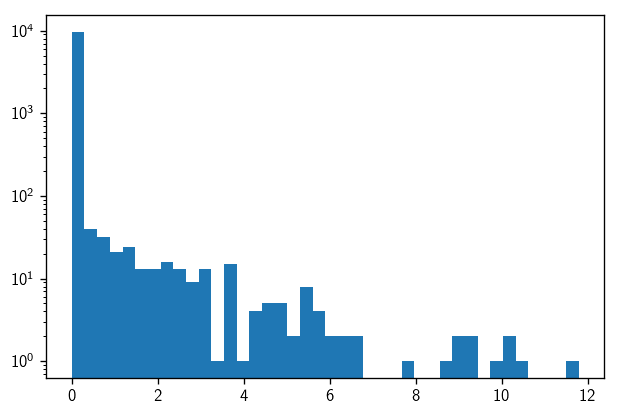

In [25]:
plt.figure()
plt.hist(bg_tss, bins=40)
plt.yscale("log")
plt.show()

### Plot sensitivity and discovery potential afo declination (or least detectable signal 3s at 90%)

In [16]:
%time flu_sens = np.array ([get_sens(sd, beta=0.9, batch_size=10000, mp_cpus=5) for sd in sindecs])

Working on sin(δ) = -1.00, t_100 = 1.00e+03...
Start time: 2018-12-19 05:02:45.921325
Using 5 cores.
* Starting initial scan for 90% of 200 trials with TS >= 0.000...
  n_sig = 3.000 ... frac = 0.94500
* Generating batches of 10000 trials...
n_trials | n_inj    0.00    1.20    2.40    3.60    4.80    6.00  | n_sig (relative error)
10000    |          0.1%   66.9%   89.1%   96.5%   98.9%   99.6%  |      2.501 (+/-  1.2%) [spline]
End time: 2018-12-19 05:03:04.893027
Elapsed time: 0:00:18.971702
sin(δ) = -1.00 | E0^2 F(E0) = 1.181e+00
Working on sin(δ) = -0.80, t_100 = 1.00e+03...
Start time: 2018-12-19 05:03:06.010892
Using 5 cores.
* Starting initial scan for 90% of 200 trials with TS >= 0.000...
  n_sig = 3.000 ... frac = 0.94500
* Generating batches of 10000 trials...
n_trials | n_inj    0.00    1.20    2.40    3.60    4.80    6.00  | n_sig (relative error)
10000    |          0.3%   69.3%   90.0%   96.7%   99.1%   99.8%  |      2.400 (+/-  1.4%) [spline]
End time: 2018-12-19 05:03:2

In [17]:
%time flu_disc = np.array ([get_sens(sd, beta=.9, nsigma=3, batch_size=10000, bg_factor=100, mp_cpus=20) for sd in sindecs])

Working on sin(δ) = -1.00, t_100 = 1.00e+03...
Performing 74080 background trials using 20 cores:
      74080/74080 trials complete.   
Start time: 2018-12-19 05:09:47.020582
Using 20 cores.
* Starting initial scan for 90% of 200 trials with TS >= 0.000...
  n_sig = 3.000 ... frac = 0.92500
* Generating batches of 10000 trials...
n_trials | n_inj    0.00    1.20    2.40    3.60    4.80    6.00  | n_sig (relative error)
10000    |          0.1%   67.1%   89.5%   96.9%   98.8%   99.6%  |      2.455 (+/-  1.4%) [spline]
End time: 2018-12-19 05:09:59.064438
Elapsed time: 0:00:12.043856
sin(δ) = -1.00 | E0^2 F(E0) = 1.159e+00
Working on sin(δ) = -0.80, t_100 = 1.00e+03...
Performing 74080 background trials using 20 cores:
      74080/74080 trials complete.   
Start time: 2018-12-19 05:10:03.070018
Using 20 cores.
* Starting initial scan for 90% of 200 trials with TS >= 4.324...
  n_sig = 3.000 ... frac = 0.94000
* Generating batches of 10000 trials...
n_trials | n_inj    0.00    1.20    2.4

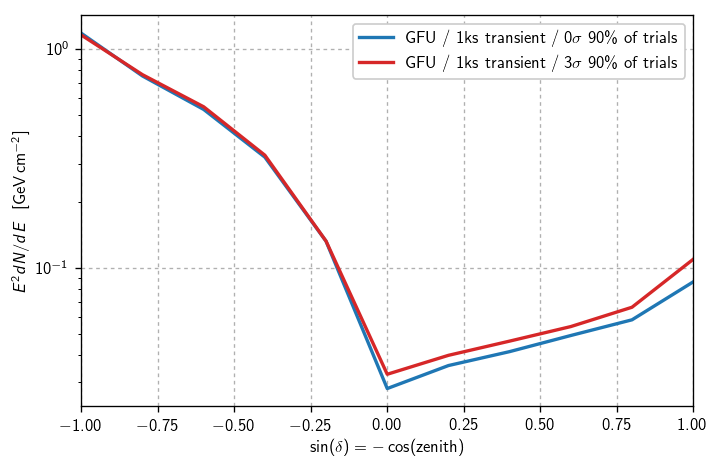

[-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ] 
 [1.18052257 0.7532685  0.52978182 0.32077856 0.13244004 0.02812971
 0.03582096 0.04147674 0.04913959 0.05795252 0.08636922] 
 [1.15865794 0.76359011 0.54480107 0.32735169 0.13262347 0.03268829
 0.03988741 0.04632446 0.05398129 0.06615143 0.10951492]


In [19]:
plt.plot()
plt.plot (sindecs, flu_sens, label='GFU / 1ks transient / $0\sigma$ $90\%$ of trials')
plt.plot (sindecs, flu_disc, label='GFU / 1ks transient / $3\sigma$ $90\%$ of trials')
plt.xlabel (r'$\sin(\delta)=-\cos(\text{zenith})$')
plt.ylabel (r'$E^2 dN/dE~~[\text{GeV}\,\text{cm}^{-2}]$')
plt.xlim (sindecs.min(), sindecs.max())
#plt.ylim (0, .25)
plt.legend ()
plt.tight_layout()
plt.grid()
plt.yscale("log")
#plt.savefig("Sens_en_DP_1ks_GRB.pdf",bbox_inches='tight')  # Check if flux should be in s^-1
plt.show()

print(sindecs, "\n", flu_sens, "\n", flu_disc)

### Calculate the sensitivity and discovery potential (or least detectable signal 3s at 90%) for GRBs in the GRBweb catalogue

In [23]:
mp_cpus    = 10

flux    = hyp.PowerLawFlux (gamma=2, energy_range=(0, np.inf))
tr      = get_tr(src[:2], ana, flux=flux, mp_cpus=10) # Works for src[i] for some reason 

nsigma     = 3
n_sig_step = 3
bg_factor  = 50

N  = int (np.ceil(bg_factor / stats.norm.sf (nsigma)))
c  = dists.Chi2TSD (tr.get_many_fits (N, mp_cpus=mp_cpus))
ts = c.isf_nsigma (nsigma)

batch_size = 1000
n_sig_step = 3

sens         = tr.find_n_sig (ts, beta=0.9, coverage=2, n_sig_step=n_sig_step, first_batch_size=min (batch_size, 200), batch_size=batch_size, max_batch_size=batch_size, mp_cpus=mp_cpus)
flux_sens    = tr.to_E2dNdE (sens['n_sig'])
sens['flux'] = flux_sens
print (u'E0^2 F(E0) = {:.3e}'.format(flux_sens))

Performing 37040 background trials using 10 cores:
      37040/37040 trials complete.   
Start time: 2018-11-27 09:50:21.498796
Using 10 cores.
* Starting initial scan for 90% of 200 trials with TS >= 4.609...
  n_sig = 3.000 ... frac = 0.92500
* Generating batches of 1000 trials...
n_trials | n_inj    0.00    1.20    2.40    3.60    4.80    6.00  | n_sig (relative error)
1000     |          0.1%   70.3%   89.3%   96.1%   98.4%   99.7%  |      2.486 (+/-  4.4%) [spline]
End time: 2018-11-27 09:50:32.477416
Elapsed time: 0:00:10.978620
E0^2 F(E0) = 2.820e-02


In [19]:
sens

{'flux': 0.06868792333745746,
 'info': {'CLs': array([0.002, 0.739, 0.968, 0.997, 0.999, 1.   ]),
  'dof': 10,
  'loc': 0,
  'n_sig': 3.6935904978092218,
  'n_sig_chi2cdf': inf,
  'n_sig_spline': 3.6935904978092218,
  'n_sigs': array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. ]),
  'params': [10, 0, 1.00000000002],
  'scale': 1.00000000002,
  'sigmas': array([0.0014128 , 0.01388809, 0.00556561, 0.00172945, 0.0009995 ,
         0.0009995 ]),
  'spline': <scipy.interpolate._cubic.PchipInterpolator at 0x7f212fee5c50>,
  'ts_beta': 0.9,
  'ts_from_fit': True,
  'ts_nsigma': 0,
  'ts_threshold': 5.940092888931567},
 'n_sig': 3.6935904978092218,
 'n_sig_error': 0.017704261559819117,
 'n_sig_error_history': array([0.01770426]),
 'n_sig_history': array([3.6935905]),
 'n_trials_history': [1000],
 'tss': {0.0: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.99483794e-01, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e

# Investigating the azimuthal asymmetry & smoothing for `BgAzimuthSinDecParameterization`

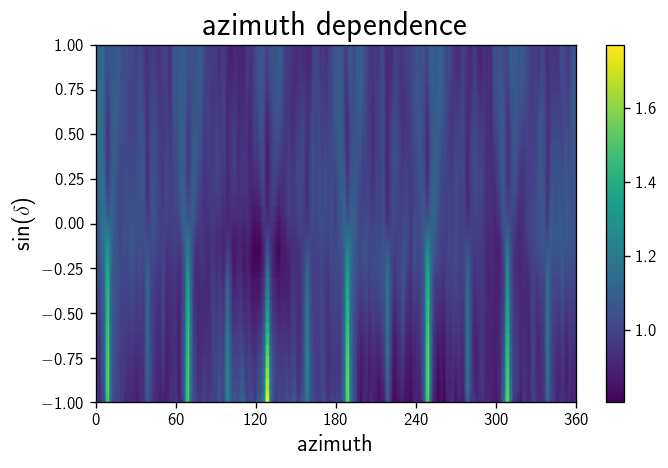

In [15]:
b  = bg_space_param = pdf.BgAzimuthSinDecParameterization (a.bg_data, hkw=a.kw_space_bg['hkw'], smooth=(1,4)) # smooth should depend on n_bins or events in bins?
b2 = sindec_param   = pdf.BgSinDecParameterization (a.data, hkw=a.kw_space_bg['hkw'])
plt.figure(figsize=(20, 16))
fig, ax = plt.subplots ()
h = b.h.transform_bins (np.degrees, [0])
hl.plot2d (ax, h, cbar=True)
plt.title (r'azimuth dependence', size=20)
plt.xlabel (r'azimuth', size=14)
plt.ylabel (r'$\sin(\delta)$', size=14)
plt.xticks (np.r_[:361:60])
plt.tight_layout ()
plt.savefig("Azimuth_dependence_GFU_with_1_4_smoothing.jpg",bbox_inches='tight')
plt.show()

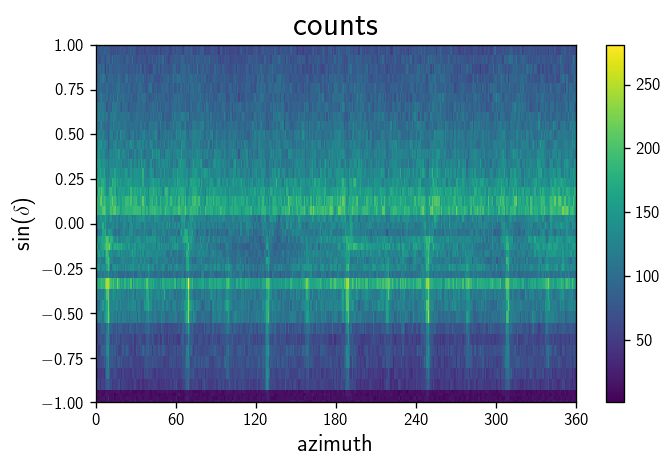

In [16]:
fig, ax = plt.subplots ()
h_count = hl.hist_like (b.h, (data.azimuth, data.sindec)).transform_bins (np.degrees, [0])
hl.plot2d (ax, h_count, cbar=True)
ax.set_title (r'counts', size=20)
ax.set_xlabel (r'azimuth', size=14)
ax.set_ylabel (r'$\sin(\delta)$', size=14)
ax.set_xticks (np.r_[:361:60])
plt.tight_layout ()
plt.savefig("Azimuth_sind_counts.jpg",bbox_inches='tight')

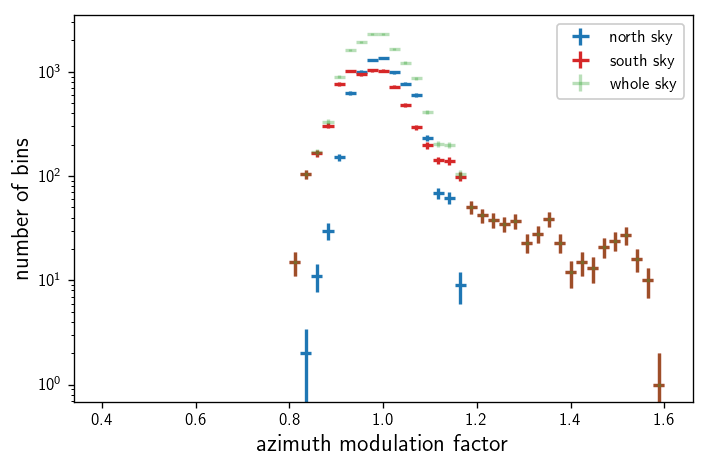

In [18]:
fig, ax = plt.subplots ()
kw = dict (bins=51, range=(.4, 1.6))
# h[:,a:b] is a 2d histogram with the full azimuth range & those sin_dec bins whose value falls between a&b
hl.plot1d (ax, hl.hist (h[:,0:].values.ravel(), **kw), crosses=True, label='north sky')
hl.plot1d (ax, hl.hist (h[:,:0].values.ravel(), **kw), crosses=True, label='south sky')
hl.plot1d (ax, hl.hist (h.values.ravel(), **kw), crosses=True, label='whole sky', alpha=.33)
ax.set_xlabel (r'azimuth modulation factor', size=14)
ax.set_ylabel ('number of bins', size=14)
ax.legend ()
plt.yscale("log")
plt.tight_layout ()
plt.savefig("Azimuth_modulation_factor.jpg",bbox_inches='tight')

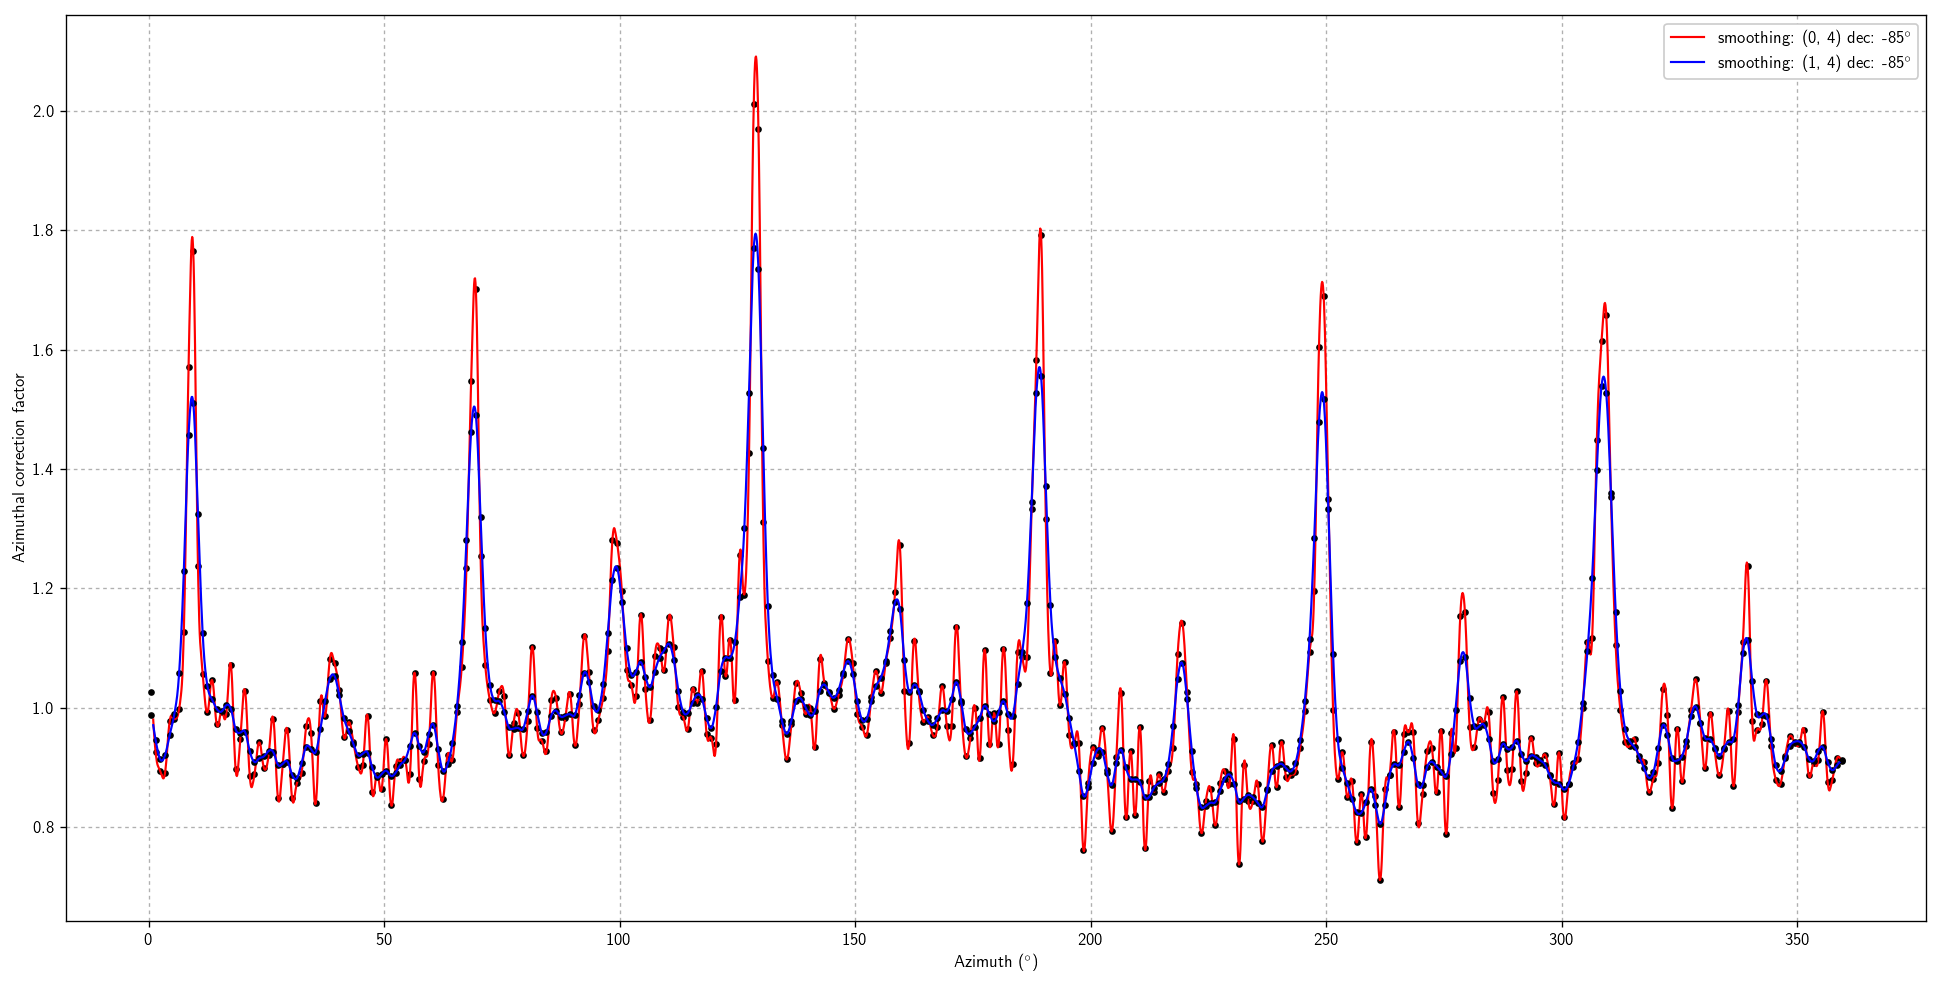

In [20]:
linestyles    = ['-','--','-.']
colors        = ["red","blue","green"]

plt.figure(figsize=(20, 10))

for j in range(0,2):
    smoothing = (j, 4)
    b  = bg_space_param = pdf.BgAzimuthSinDecParameterization (a.data, hkw=a.kw_space_bg['hkw'], smooth=smoothing) # smooth should depend on n_bins or events in bins?
    b2 = sindec_param   = pdf.BgSinDecParameterization (a.data, hkw=a.kw_space_bg['hkw'])

    h = b.h.transform_bins (np.degrees, [0])
    
    x_values = h.centers[0]
    h_north = h[:,np.sin(np.radians(85)):]
    h_south = h[:,:np.sin(np.radians(-85))]

    class events():
        def __init__(self, a, d):
            self.azimuth = a
            self.dec     = d
        def __len__(self):
            return len(self.azimuth)

        def __getitem__(self, key):
            return self.dec[key]
    N       = 3590
    azimuth = np.radians(np.linspace(1, 359, N))
    decs    = np.linspace(-85, 85, 2)
    ys      = []
    for dec in decs[:1]:
        dec     = np.radians(dec)*np.ones((N))
        ev      = events(azimuth, dec)
        ys.append( b(ev)/b2(ev)[0] )


    #plt.plot(x_values, h_north.values[:, 0], '.', color="black")#linewidth=1)
    plt.plot(x_values, h_south.values[:, 0], '.', color="black")#linewidth=1)
    for i, y in enumerate(ys):
        plt.plot(np.degrees(azimuth), y, linestyle=linestyles[i], color=colors[j], label=r"smoothing: (%i, %i)  dec: %i$^\circ$"%(smoothing[0], smoothing[1], decs[i]), linewidth=1.3)

legend = plt.legend(loc="best")
plt.xlabel("Azimuth ($^\circ$)")
plt.ylabel("Azimuthal correction factor")
plt.grid()
plt.savefig("Azimuthal_splines.jpg",bbox_inches='tight')
plt.show()

